In [294]:
import numpy as np  # NumPy package for arrays, random number generation, etc
import matplotlib.pyplot as plt  # For plotting
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from sklearn.neighbors import KDTree
import networkx as nx

from faker import random_point_processes as rpp

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import logging
logging.basicConfig(level=logging.INFO)

369 centres. 37017 households.


(-130.70563997030763, 2151.426731134429, -167.1448296050943, 2145.666214923409)

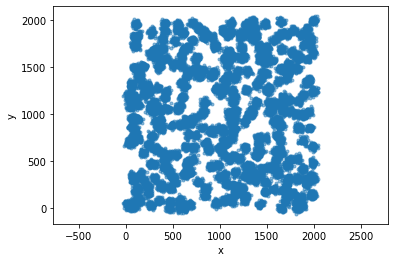

In [156]:
bbox = np.array([[0,0],[2000,2000]])

xx, yy, xx_parent_repeated, yy_parent_repeated, xx_parent, yy_parent, centre_ids = rpp.thomas_cluster_process(
    xmin = bbox[0][0],
    xmax = bbox[1][0],
    ymin = bbox[0][1],
    ymax = bbox[1][1],
    lambda_parent = .0001, # density of parent Poisson point process
    lambda_daughter = 100, # mean number of points in each cluster
    sigma = 20 # sigma for normal variables (ie random locations) of daughters
)
print(len(xx_parent), 'centres.', len(xx), 'households.')
plt.scatter(xx, yy, alpha=0.5, marker='.')
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')

In [113]:
# adjust bbox
maxx, minx = max(xx), min(xx)
maxy, miny = max(yy), min(yy)
bbox = np.array(((minx, miny), (maxx, maxy)))

In [114]:
pop_size = len(xx)
pop_size

18430

In [115]:
def minmax(array):
    assert isinstance(array, np.ndarray)
    return (array - min(array)) / (max(array) - min(array))

In [116]:
# build some hidden features for households

In [117]:
# points
hh_locs = [Point(x, y) for x, y in zip(xx,yy)]
centres = [Point(x, y) for x, y in zip(xx_parent, yy_parent)]
hh_centres = [Point(x, y) for x, y in zip(xx_parent_repeated, yy_parent_repeated)]

hh_dist_to_centre = np.array([x.distance(y) for x, y in zip(hh_locs, hh_centres)])
hh_dist_to_centre_mm = minmax(hh_dist_to_centre)

In [118]:
# arrays
hh_loc_array = np.vstack((xx, yy)).T
centre_array = np.vstack((xx_parent, yy_parent)).T

In [119]:
# centres tree
tree = KDTree(centre_array)

dist_closest_centre, _ = tree.query(hh_loc_array, dualtree=True, k=1)
dist_closest_centre = dist_closest_centre.reshape(-1)
hh_dist_closest_centre_mm = minmax(dist_closest_centre)

nearest_dist, _ = tree.query(hh_loc_array, dualtree=True, k=3)
dist_closest_centres = nearest_dist.sum(axis=1)
hh_dist_closest_centres_mm = minmax(dist_closest_centres)

In [120]:
# hh locations tree
tree = KDTree(hh_loc_array)
density = tree.query_radius(hh_loc_array, count_only=True, r=1)
hh_density_mm = minmax(density)

In [121]:
xx_mm = minmax(xx)
yy_mm = minmax(yy)
centre_ids_mm = minmax(centre_ids)

In [122]:
# build some attributes based on these hidden features and on each other

In [123]:
def gen_hidden(xx, yy, hh_density_mm):
    """
    hidden household variable
    """
    p1 = np.random.poisson(xx*10)
    p2 = np.random.poisson(hh_density_mm*10)
    p3 = np.random.poisson(hh_density_mm*xx*10)
    p4 = np.random.poisson(((xx - .5)*10)**2)
    p5 = np.random.poisson(yy*10)
    choice = np.array([p1,p2,p3,p4,p5])
    choice = choice/sum(choice)
    return np.random.choice([1,2,3,4,5], p=choice)

In [124]:
def gen_hh_count(hidden, density):
    """
    num people in household
    """
    p1 = density*50 + hidden*2
    p2 = density*40 + hidden*4
    p3 = density*30 + hidden*6
    p4 = density*20 + hidden*8
    p5 = density*10 + hidden*10
    choice = np.array([p1,p2,p3,p4,p5])
    choice = choice/sum(choice)
    return np.random.choice([1,2,3,4,5], p=choice)

In [125]:
hh_hidden = np.array([gen_hidden(x,y,d) for x,y,d in zip(xx_mm, yy_mm, hh_density_mm)])
hh_count = np.array([gen_hh_count(e,d) for e,d in zip(hh_hidden, hh_density_mm)])
hh_indexes = np.array(range(len(xx_mm)))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


In [126]:
def gen_num_children(count, hidden, hh_dist_closest_centre_mm):
    """
    1 person = a
    2 persons = aa, ac
    3 persons = aaa, aac, acc
    4 people = aaaa, aaac, aacc, accc
    5 people = aaaaa, aaaac, aaacc, aaccc, acccc
    
    """
    if count == 1:
        return 0
    
    else:
        pchild = hh_dist_closest_centre_mm * count / 2
        padult = hidden / 5
        p = pchild / (pchild + padult)
        return np.random.binomial((count - 1), p, size=None)

In [127]:
hh_children = np.array([gen_num_children(c,h,d) for c,h,d in zip(hh_count, hh_hidden, hh_dist_closest_centre_mm)])

In [128]:
sum(hh_count)

66821

In [129]:
sum(hh_children)

22646

In [130]:
def gen_age_group(hh_children, hh_hidden, hh_density_mm):
    
    if hh_children:
        return int(np.random.uniform(16, 16 + hh_hidden) + np.random.triangular(0, 3 * hh_hidden, 20))
    
    old = 50 + (2*hh_hidden)
    adult = 30 + (2*hh_hidden)
    return np.random.choice(
        [
            int(np.random.poisson(old)),
            int(np.random.poisson(adult)),
        ],
        p=(1-hh_density_mm, hh_density_mm)
    )

In [131]:
hh_age_group = np.array([gen_age_group(c,h,d) for c,h,d in zip(hh_children, hh_hidden, hh_density_mm)])

In [132]:
def get_income(hh_dist_closest_centres_mm, hh_density_mm):
    return (15 + np.random.poisson(5*(hh_dist_closest_centres_mm + 1 - hh_density_mm))*5)*1000

In [133]:
hh_income = np.array([get_income(d, s) for d, s in zip(hh_dist_closest_centres_mm, hh_density_mm)])
hh_income_mm = minmax(hh_income)

In [134]:
def get_cars(hh_hidden, income_mm, density_mm, hh_count, hh_children):
    adults = hh_count - hh_children
    p1 = income_mm * (1 - density_mm)
    if hh_hidden < 3:
        p1 /=2
    p2 = p1 / 2
    return np.random.binomial(1, p1) + np.random.binomial(adults-1, p2)

In [135]:
hh_cars = np.array([get_cars(a,b,c,d,e) for a,b,c,d,e in zip(hh_hidden, hh_income_mm, hh_density_mm, hh_count, hh_children)])

In [148]:
from faker.tree import RegularBlock

In [149]:
hh_locs_array = np.stack(
    (
        hh_indexes,
        xx,
        yy
    ),
    axis=1
)
hh_locs_array.shape

(18430, 3)

In [150]:
grid = RegularBlock(bbox=bbox, data=hh_locs_array, max_points=1000)

In [344]:
geom_data = []
geom_maps = []
G = nx.DiGraph()
idx = 0

for block in grid.traverse():
    
    if block.leaf:
        geom_data.append({'block_id': idx, 'density': block.density(), 'geometry': block.district()})
        geom_maps.append(block.build_point_data(idx))
        
    block.build_block_net(idx, G)
    
    idx += 1
        
hh_grid_ids = np.concatenate(geom_maps)
hh_grid_ids = hh_grid_ids[hh_grid_ids[:,0].argsort()]
hh_grid_ids = hh_grid_ids[:,1]

In [345]:
block_df = pd.DataFrame(geom_data)
block_gdf = gpd.GeoDataFrame(block_df, geometry='geometry')

block_gdf.head()

,block_id,density,geometry
0,2,0.002538,"POLYGON ((-40.41995 -3.30193, 5.53262 -3.30193..."
1,3,0.043775,"POLYGON ((-40.41995 30.99970, 5.53262 30.99970..."
2,5,0.116733,"POLYGON ((5.53262 30.99970, 28.50890 30.99970,..."
3,6,0.149723,"POLYGON ((5.53262 48.15051, 28.50890 48.15051,..."
4,7,0.195401,"POLYGON ((28.50890 48.15051, 51.48518 48.15051..."


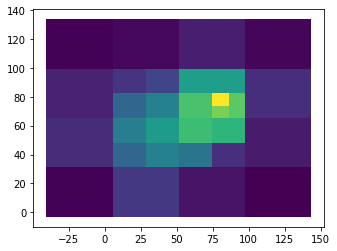

In [346]:
block_gdf.plot(column='density')

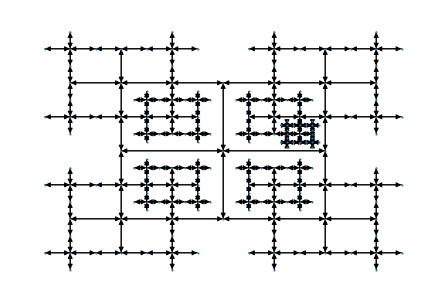

In [347]:
pos = {k: v['pos'] for k, v in G.nodes.items()}
nx.draw(G, pos=pos, node_size=1)

In [279]:
# assemble hh variables            
hh_array = np.stack(
    [
        hh_indexes,
        hh_grid_ids,
        centre_ids,
        hh_dist_to_centre_mm,
        hh_dist_closest_centres_mm,
        hh_density_mm,
        hh_hidden,
        hh_count,
        hh_children,
        hh_age_group,
    ]
, axis=1)

In [280]:
hh_array.shape

(1459, 10)

In [281]:
agent_hh_array = np.repeat(hh_array, hh_count, axis=0)

In [282]:
agent_hh_array.shape

(5088, 10)

In [283]:
agent_index = np.array(range(len(agent_hh_array)))

In [284]:
# get ident for each agent in hh
# _, _, counts = np.unique(sorted_records_array, return_counts=True, return_index=True)
agent_hh_index = np.array([i for c in hh_count for i in range(c)])

In [285]:
agent_hh_index.shape

(5088,)

In [286]:
def get_is_adult(agent_hh_index, hh_array):
    num_children = hh_array[-2]
    if agent_hh_index < num_children:
        return 0
    else:
        return 1

In [287]:
agent_is_adult = np.array([get_is_adult(i,c) for i,c in zip(agent_hh_index, agent_hh_array)])

In [288]:
agent_is_adult.shape

(5088,)

In [289]:
def get_gender(agent_hh_index, agent_hh_array, agent_is_adult):
    
    if not agent_is_adult:
        pman=.49
        return np.random.choice([0, 1], p=[pman, 1-pman])
    
    elif agent_hh_array[-1]:  # number of children
        number_adults = agent_hh_array[-3] - agent_hh_array[-2]
        adult_index = agent_hh_index - agent_hh_array[-2]
        p = agent_hh_array[-4] / 10 # hidden hh
        if adult_index % 2:
            return np.random.choice([0, 1], p=[1 - p, p])
        else:
            return np.random.choice([0, 1], p=[p, 1-p])
    else:
        return np.random.choice([0, 1], p=[.48, .52])
        

In [290]:
agent_genders = np.array([get_gender(i,c,a) for i,c,a in zip(agent_hh_index, agent_hh_array, agent_is_adult)])

In [291]:
agent_genders

array([1, 1, 0, ..., 1, 0, 1])

In [292]:
def get_age(agent_hh_array, agent_is_adult):
    
    hh_hidden = agent_hh_array[-4]
    hh_age_group = agent_hh_array[-1]
    
    if not agent_is_adult:
        return int(np.random.uniform(0, 11) + np.random.triangular(0, hh_hidden, 6))
    
    return hh_age_group + int(np.random.poisson(2))
    

In [293]:
agent_ages = np.array([get_age(i,c) for i,c in zip(agent_hh_array, agent_is_adult)])

In [ ]:
def get_dist_pt(dist_closest_centre):
    return np.random.normal(1-dist_closest_centre)**2

In [ ]:
dist_pt = np.array([get_dist_pt(d) for d in dist_closest_centre])

In [ ]:
income = np.array([get_income(d) for d in dist_closest_centres_mm])

In [ ]:
income_mm = minmax(income)

In [ ]:
def get_car(ethnicity, income_mm, density_mm):
    p = income_mm * (1 - density_mm)
    if ethnicity < 3:
        p /=2 
    choice = np.array([p, 1-p])
    return np.random.choice([1, 0], p=choice)

In [ ]:
has_car = np.array([get_car(e, i, d) for e, i, d in zip(ethnicity, income_mm, density_mm)])

In [ ]:
# build df

In [ ]:
data_dict =  {
        'x': xx,
        'y': yy,
        'centre_id': centre_ids,
        'dist_centre': dist_to_centre,
        'density': density,
        'gender': genders,
        'ethnicity': ethnicity,
        'hh_people': hh_people,
        'age': age,
        'dist_pt': dist_pt,
        'income': income,
        'has_car': has_car
    }

In [ ]:
for k,v in data_dict.items():
    print(k, len(v))

In [ ]:
data = pd.DataFrame(data_dict)

In [ ]:
data.head()

In [ ]:
data.to_csv('data.csv', index=False)

In [ ]:
from faker.tree import RegularBlock
import numpy as np

In [ ]:
xx = np.array((2,1,2,3,6,1,9,1,7))
yy = np.array((0,1,1,3,3,4,1,9,9))

In [ ]:
locs = np.stack((xx,yy), axis=1)

In [ ]:
ind = np.array(range(len(locs))).reshape((-1,1))

In [ ]:
data = np.concatenate((ind,locs), axis=1)
data

In [ ]:
np.concatenate([data,data])

In [ ]:
a = np.ones((3)) * 3
a

In [ ]:
np.concatenate((a,a))

In [ ]:
bbox = np.array([[0,0],[10,10]])

In [ ]:
grid = RegularBlock(bbox, data, 4)

In [ ]:
for leaf in grid.traverse():
    if leaf.leaf:
        print(leaf.centre)

In [ ]:
bbox = np.array([[0,0],[10,10]])
print(bbox)
centre = bbox.mean(axis=0)
print(centre)
left = data[:, 1] < centre[0]
bottom = data[:, 2] < centre[1]
print(left)
print(bottom)
# bottom left
minx, miny, maxx, maxy = bbox[0, 0], bbox[0, 1], centre[0], centre[1]
bbox = np.array([[minx, miny], [maxx, maxy]])
bbox

In [ ]:
bb = np.array([[2,-2],[10,10]])
bb

In [ ]:
bb.mean(axis=0)

In [ ]:
from shapely.geometry import Polygon, MultiPolygon
p1 = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
p2 = Polygon([(1, 0), (2, 0), (2, 1), (1, 1)])
m = MultiPolygon([p1,p2])

In [ ]:
x,y = m.exterior.xy
plt.plot(x, y)

In [46]:
from enum import Enum, IntEnum
class QuadTree:
    "Quadtree"
   
    class Tag(Enum):
        NONE = 0
        SELECTED = 1
        NEIGHBOR = 2
    
    class Child(IntEnum):
        NW = 0
        NE = 1
        SW = 2
        SE = 3

In [49]:
a = ['a','b','c','d']
quad = QuadTree
a[quad.Child.NE]

'b'